In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import heapq
import cv2
import osmnx as ox
import networkx as nx


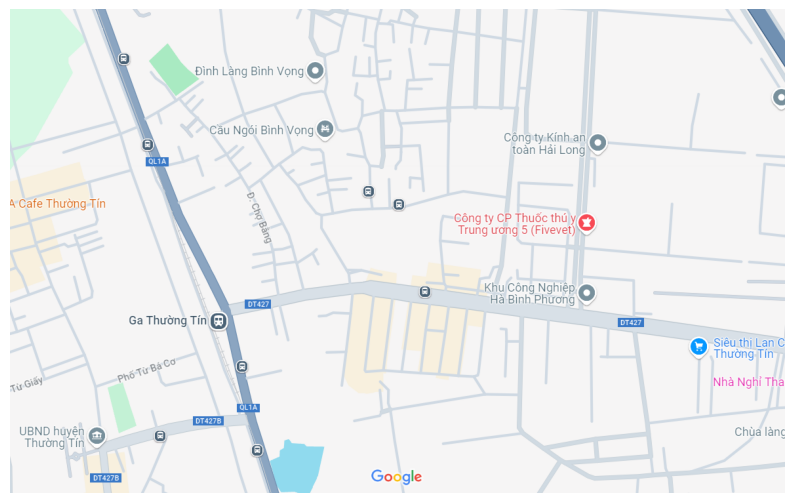

Image dimensions: 1182x738


array([[[226, 248, 211],
        [226, 248, 211],
        [226, 248, 211],
        ...,
        [245, 245, 246],
        [245, 245, 246],
        [245, 245, 246]],

       [[226, 248, 211],
        [226, 248, 211],
        [226, 248, 211],
        ...,
        [245, 245, 246],
        [245, 245, 246],
        [245, 245, 246]],

       [[226, 248, 211],
        [226, 248, 211],
        [226, 248, 211],
        ...,
        [245, 245, 246],
        [245, 245, 246],
        [245, 245, 246]],

       ...,

       [[226, 218, 208],
        [226, 218, 208],
        [226, 218, 208],
        ...,
        [245, 245, 246],
        [245, 245, 246],
        [245, 245, 246]],

       [[226, 218, 208],
        [226, 218, 208],
        [226, 218, 208],
        ...,
        [245, 245, 246],
        [245, 245, 246],
        [245, 245, 246]],

       [[226, 218, 208],
        [226, 218, 208],
        [226, 218, 208],
        ...,
        [245, 245, 246],
        [245, 245, 246],
        [245, 245, 246]]

In [3]:


img = cv2.imread('MAP.png')

if img is not None:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    
    height, width = img.shape[:2]
    print(f"Image dimensions: {width}x{height}")
else:
    print("Error: Could not read the image. Please check if 'MAP.png' exists in the current directory.")

img



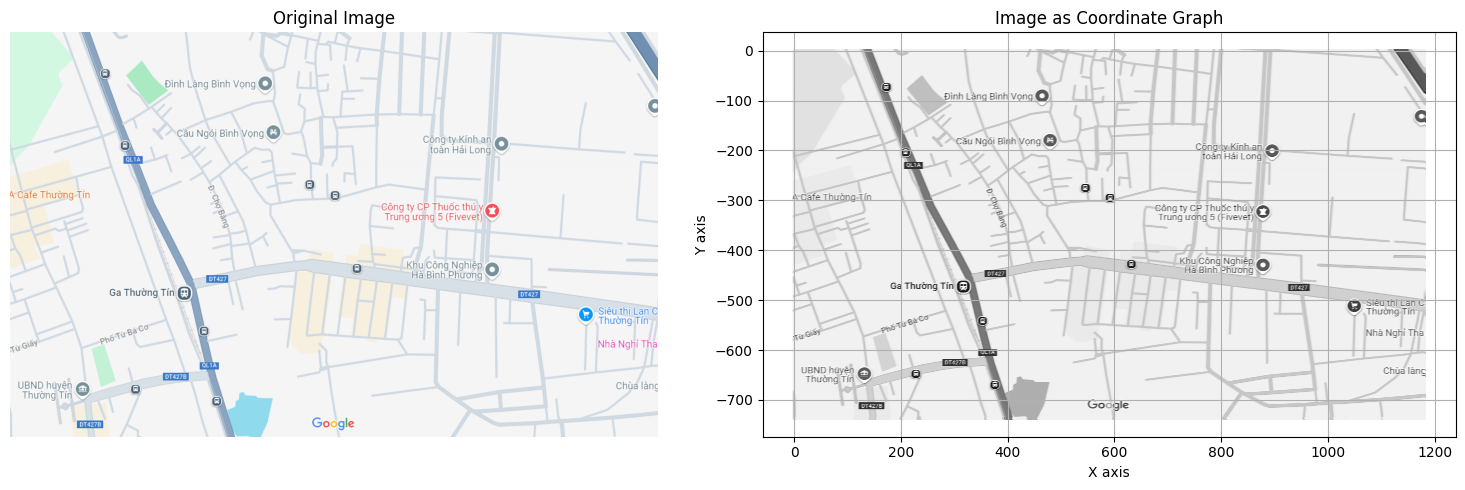

Graph dimensions: Width=1181, Height=737


In [4]:
# Đọc ảnh và chuyển sang ảnh xám
img = cv2.imread('MAP.png')
if img is not None:
    # Chuyển sang ảnh xám
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Tạo lưới tọa độ
    y, x = np.mgrid[0:gray.shape[0], 0:gray.shape[1]]
    
    # Tạo figure với 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Hiển thị ảnh gốc
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Hiển thị đồ thị tọa độ
    ax2.scatter(x.flatten(), -y.flatten(), c=gray.flatten(), cmap='gray', s=1)
    ax2.set_title('Image as Coordinate Graph')
    ax2.set_xlabel('X axis')
    ax2.set_ylabel('Y axis')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Graph dimensions: Width={x.max()}, Height={y.max()}")
else:
    print("Error: Could not read the image")

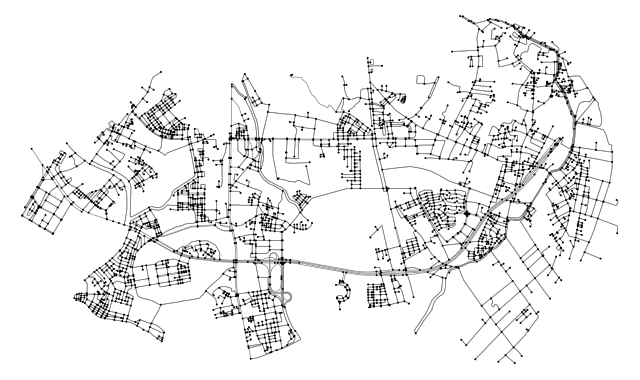

In [5]:

place_name = "Hoang Mai, Hanoi, Vietnam"

G = ox.graph_from_place(place_name, network_type="drive")

fig, ax = ox.plot_graph(G, node_size=2, edge_linewidth=0.5, bgcolor="white", node_color="black", edge_color="gray")


In [8]:
# In thông tin đồ thị
print(G)
edges = list(G.edges(data=True, keys=True))[:5]
for u, v, k, data in edges:
    print(f"{u} → {v}, key = {k}, data = {data}")

print(edges[:5])

MultiDiGraph with 3085 nodes and 7793 edges
84806187 → 5710236733, key = 0, data = {'osmid': 600537341, 'highway': 'residential', 'oneway': False, 'reversed': False, 'length': 45.45006118107132}
84806187 → 84806193, key = 0, data = {'osmid': 179477523, 'highway': 'primary', 'lanes': '2', 'name': 'Đường Nguyễn Khoái', 'oneway': False, 'reversed': False, 'length': 261.851978005213, 'geometry': <LINESTRING (105.88 20.966, 105.88 20.966, 105.88 20.966, 105.88 20.966, 105...>}
84806187 → 4023430891, key = 0, data = {'osmid': 179477523, 'highway': 'primary', 'lanes': '2', 'name': 'Đường Nguyễn Khoái', 'oneway': False, 'reversed': True, 'length': 321.5038130006379, 'geometry': <LINESTRING (105.88 20.966, 105.88 20.966, 105.879 20.966, 105.879 20.966, 1...>}
84806193 → 440776411, key = 0, data = {'osmid': 179477523, 'highway': 'primary', 'lanes': '2', 'name': 'Đường Nguyễn Khoái', 'oneway': False, 'reversed': False, 'length': 30.593060608230815, 'geometry': <LINESTRING (105.882 20.967, 105.882

In [9]:

ox.save_graphml(G, "hoangmai_hanoi_graph.graphml")  # Lưu dưới dạng file GraphML
Hoang_Mai_maps = ox.load_graphml("hoangmai_hanoi_graph.graphml")  # Tải lại khi cần


In [57]:
Edges =list (Hoang_Mai_maps.edges(data=True, keys=True))
Graph ={}
for node in Hoang_Mai_maps.nodes:
    Graph[node] = []
for node in Hoang_Mai_maps.nodes:
    for edges in Edges:
        if edges[0]== node:
                Graph[node].append([edges[1],edges[3]['length']]) 

            
    

In [58]:
for i in Graph.keys():
    print (i,Graph[i])
    print("\n")

84806187 [[5710236733, 45.45006118107132], [84806193, 261.851978005213], [4023430891, 321.5038130006379]]


84806193 [[440776411, 30.593060608230815], [84806187, 261.851978005213], [5710236730, 64.29430308942017]]


84806195 [[440776411, 8.971300890061357], [84806203, 292.1447653842876], [5710236727, 34.99086363422213]]


84806203 [[5716440344, 37.60599484129804], [84806195, 292.14476538428755], [5710669638, 74.6435752755397]]


84806238 [[5719587967, 15.550751284150186], [5719588003, 17.635302626068384], [5719587978, 154.05868787159224], [5719587981, 557.4712654667236]]


84806254 [[5716815995, 11.89532767740151], [5719176969, 49.01184482757387], [84806255, 28.798900346716124]]


84806255 [[84806254, 28.798900346716124], [5719176970, 45.84941626090534], [84806261, 262.1683543135781]]


84806261 [[5716816013, 67.452474330803], [5716647636, 294.0230116896829], [84806255, 262.16835431357805]]


84806276 [[84806282, 98.97433580111172], [5707205383, 230.32939539887806]]


84806282 [[571644

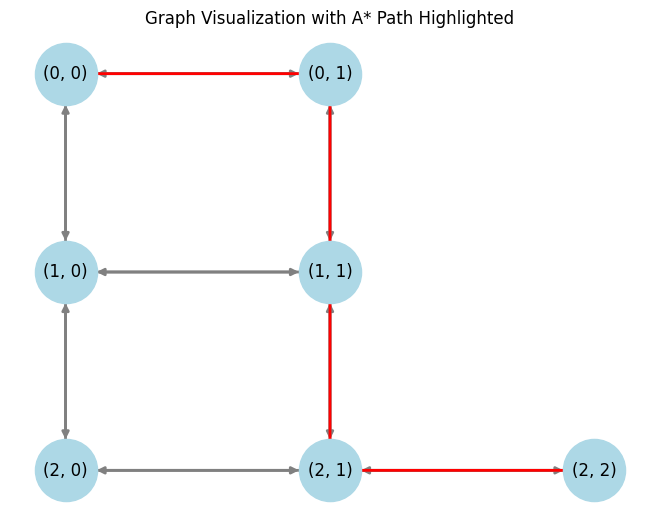

In [ ]:


def heuristic(a, b):
    return np.norm

def a_star(graph, start, goal):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {node: float('inf') for node in graph}
    g_score[start] = 0
    f_score = {node: float('inf') for node in graph}
    f_score[start] = heuristic(start, goal)

    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            return reconstruct_path(came_from, current)

        for neighbor, cost in graph[current].items():
            tentative_g_score = g_score[current] + cost
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None

def reconstruct_path(came_from, current):
    total_path = [current]
    while current in came_from:
        current = came_from[current]
        total_path.append(current)
    total_path.reverse()
    return total_path

def path_to_edges(path):
    return [(path[i], path[i + 1]) for i in range(len(path) - 1)]

# Define the graph
graph = {
    (0, 0): {(1, 0): 1, (0, 1): 1},
    (1, 0): {(0, 0): 1, (1, 1): 1, (2, 0): 1},
    (0, 1): {(0, 0): 1, (1, 1): 1},
    (1, 1): {(1, 0): 1, (0, 1): 1, (2, 1): 1},
    (2, 0): {(1, 0): 1, (2, 1): 1},
    (2, 1): {(2, 0): 1, (1, 1): 1, (2, 2): 1},
    (2, 2): {(2, 1): 1}
}

start = (0, 0)
goal = (2, 2)

# Use NetworkX to create the graph
G = nx.DiGraph()
for node, edges in graph.items():
    for dest, weight in edges.items():
        G.add_edge(node, dest, weight=weight)
# Get the path from A* algorithm
path = a_star(graph, start, goal)

# Plotting
pos = {node: (node[1], -node[0]) for node in graph}  # position nodes based on grid coordinates
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, edge_color='gray', width=2)
nx.draw_networkx_edges(G, pos, edgelist=path_to_edges(path), edge_color='red', width=2)
plt.title('Graph Visualization with A* Path Highlighted')
plt.show()


A Star Algorithrm 


In [ ]:
from queue import PriorityQueue
def Heuristic (start, goal) :
    return np.linalg.norm(np.array(start) - np.array(goal))
def reconstruct_path (start, goal, parent) :
    path = []
    current = goal
    while current != start:
        path.append(current)
        current = parent[current]
    path.append(start)
    path.reverse()
    return path
def A_star (start, goal, list_edge) :
    pq = PriorityQueue()
    pq.put((0, start))
    parent[start] = 0
    g_cost[start] = 0
    h_cost[start] = Heuristic(start, goal)
    f_cost[start] = g_cost[start] + h_cost[start]
    while (not pq.empty()):
        current = pq.get()[1]
        if current == goal:
            return reconstruct_path(start, goal, parent)
        for next in list_edge[current]:
            new_g_cost = g_cost[current] + np.linalg.norm(np.array(current) - np.array(next))
            if g_cost[next] > new_g_cost:
                g_cost[next] = new_g_cost
                h_cost[next] = Heuristic(next, goal)
                f_cost[next] = g_cost[next] + h_cost[next]
                pq.put((f_cost[next], next))
                parent[next] = currentq
    return []



    
    
